# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
base_path = './preprocessed data/'

# train_err = pd.read_csv(base_path + 'new_train_err.csv', parse_dates=['time'])
train_quality = pd.read_csv(base_path + 'new_train_quality.csv', parse_dates=['time'])
train_problem = pd.read_csv(base_path + 'new_train_problem.csv', parse_dates=['time'])
test_err = pd.read_csv(base_path + 'new_test_err.csv', parse_dates=['time'])
test_quality = pd.read_csv(base_path + 'new_test_quality.csv', parse_dates=['time'])
# submission = pd.read_csv("C:/Users/gmlkd/data/시스템 품질 변화로 인한 사용자 불편 예지 AI 경진대회_data/sample_submission.csv")

# Quality 분석

In [3]:
train_quality.describe()

,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
count,272452.000000,272452.000000,272452.000000,272452.000000,272452.0,272452.0,272452.000000,272452.000000,272452.000000,272452.000000,272452.000000,2.724520e+05,272452.000000,272452.000000
mean,17559.687732,10.786660,-0.068684,14.158138,0.0,0.0,224.519387,3.069664,26.486376,0.177411,106.522925,1.828710e+03,-0.092328,0.038238
std,4389.671541,759.517259,0.796227,997.273716,0.0,0.0,3969.392409,34.457646,295.315129,6.319490,4576.446638,2.441835e+04,0.333191,0.296846
min,10000.000000,-1.000000,-1.000000,-1.000000,0.0,0.0,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000e+00,-1.000000,0.000000
25%,13676.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000,0.000000
50%,17488.000000,0.000000,0.000000,0.000000,0.0,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,1.900000e+01,0.000000,0.000000
75%,21546.000000,0.000000,0.000000,0.000000,0.0,0.0,15.000000,0.000000,0.000000,0.000000,0.000000,2.020000e+02,0.000000,0.000000
max,24997.000000,157667.000000,171.000000,191859.000000,0.0,0.0,637385.000000,600.000000,7200.000000,1317.000000,397424.000000,1.910175e+06,14.000000,14.000000


In [5]:
# 값이 모두 0인 quality_3, 4는 drop
train_quality.drop(columns=['quality_3', 'quality_4'], inplace=True)

In [6]:
# 절반정도 user는 train_quality에 존재하지 않는다.
len(train_quality.user_id.unique())

8224

## 불만을 제기한 user와 quality데이터의 관계

In [6]:
# 대부분 불만을 제기한 user의 quality데이터가 수집된건지 확인
quality_user = list(train_quality.user_id.unique())
problem_user = list(train_problem.user_id.unique())

cnt = 0
for i in problem_user:
    if i in quality_user:
        cnt += 1
print(f"불만을 제기한 사람 중 quality 데이터에도 있는 경우 : {round(cnt/len(quality_user)*100, 2)}%")

# 생각보다 연관성이 높진 않다.

불만을 제기한 사람 중 quality 데이터에도 있는 경우 : 38.4%


## -1값을 갖는 quality
quality 데이터를 보면 범위가 [0 ~ ∞] 또는 [-∞ ~ ∞] 가 아니라 [-1 ~ ∞]이다. 

-1은 퀄리티의 오류값일 수 있으므로 확인

In [7]:
has_minus_user = train_quality[train_quality.quality_0 == -1].groupby('user_id')['quality_0'].count().to_frame().reset_index()
has_minus_user

,user_id,quality_0
0,10002,1
1,10004,1
2,10005,1
3,10010,1
4,10013,7
...,...,...
5562,24986,5
5563,24992,2
5564,24993,2
5565,24995,2


In [8]:
has_minus_user = has_minus_user.sort_values(ascending=False, by='quality_0')
has_minus_user.head(100)

,user_id,quality_0
1750,14701,171
2028,15475,157
4310,21641,153
452,11252,144
2260,16101,142
...,...,...
3082,18393,42
2808,17641,42
1142,13117,40
499,11399,40


In [9]:
has_minus_user[:100]['user_id']

1750    14701
2028    15475
4310    21641
452     11252
2260    16101
        ...  
3082    18393
2808    17641
1142    13117
499     11399
3315    18967
Name: user_id, Length: 100, dtype: int64

In [10]:
# 상위 100명
problem_user = len(train_problem[train_problem['user_id'].isin(has_minus_user[:100]['user_id'])].user_id.unique())
print(f"상위 100명중 불만을 제기한 사람: {problem_user/100 * 100}%")

# 상위 500명
problem_user = len(train_problem[train_problem['user_id'].isin(has_minus_user[:500]['user_id'])].user_id.unique())
print(f"상위 500명중 불만을 제기한 사람: {problem_user/500 * 100}%")

# 전체 유저 수
problem_user = len(train_problem[train_problem['user_id'].isin(has_minus_user['user_id'])].user_id.unique())
print(f"전체 유저 중 불만을 제기한 사람: {problem_user/5567 * 100}%")

상위 100명중 불만을 제기한 사람: 71.0%
상위 500명중 불만을 제기한 사람: 61.4%
전체 유저 중 불만을 제기한 사람: 41.67415124842824%


- '-1'이라는 퀄리티 값을 많이 가질수록 불만제기율이 높다.
- 다른 값들에 대해서도 확인하면서 더블 체킹을 해준다

In [11]:
# 1값을 갖는 유저들
has_1_user = train_quality[train_quality.quality_1 == 1].groupby('user_id')['quality_1'].count().to_frame().reset_index()
has_1_user = has_1_user.sort_values(ascending=False, by='quality_1')


# 상위 100명
problem_user = len(train_problem[train_problem['user_id'].isin(has_1_user[:100]['user_id'])].user_id.unique())
print(f"상위 100명중 불만을 제기한 사람: {problem_user/100 * 100}%")

# 상위 500명
problem_user = len(train_problem[train_problem['user_id'].isin(has_1_user[:500]['user_id'])].user_id.unique())
print(f"상위 500명중 불만을 제기한 사람: {problem_user/500 * 100}%")

# 전체 유저 수
problem_user = len(train_problem[train_problem['user_id'].isin(has_1_user['user_id'])].user_id.unique())
print(f"전체 유저 중 불만을 제기한 사람: {problem_user/len(has_1_user.index) * 100}%")

상위 100명중 불만을 제기한 사람: 61.0%
상위 500명중 불만을 제기한 사람: 56.2%
전체 유저 중 불만을 제기한 사람: 53.36225596529284%


In [12]:
# 0값을 갖는 유저들
has_0_user = train_quality[train_quality.quality_0 == 0].groupby('user_id')['quality_0'].count().to_frame().reset_index()
has_0_user = has_0_user.sort_values(ascending=False, by='quality_0')


# 상위 100명
problem_user = len(train_problem[train_problem['user_id'].isin(has_0_user[:100]['user_id'])].user_id.unique())
print(f"상위 100명중 불만을 제기한 사람: {problem_user/100 * 100}%")

# 상위 500명
problem_user = len(train_problem[train_problem['user_id'].isin(has_0_user[:500]['user_id'])].user_id.unique())
print(f"상위 500명중 불만을 제기한 사람: {problem_user/500 * 100}%")


# 전체 유저 수
problem_user = len(train_problem[train_problem['user_id'].isin(has_0_user['user_id'])].user_id.unique())
print(f"전체 유저 중 불만을 제기한 사람: {problem_user/len(has_0_user.index) * 100}%")

상위 100명중 불만을 제기한 사람: 67.0%
상위 500명중 불만을 제기한 사람: 56.99999999999999%
전체 유저 중 불만을 제기한 사람: 38.39698370226222%


- -1 뿐만 아니라 다른 값에 대해서도 비슷한 양상이 보이므로 -1에대한 feature를 따로 만들기에는 적합하지 않다.

## quality의 합에 따른 불만 제기율

In [8]:
# 모든 유저의 quality를 더해주는 dataframe 생성

quality_sum = pd.DataFrame({'user_id': np.arange(10000, 25000)})

for i in train_quality.columns[3:]:
    quality_group_df = train_quality.groupby('user_id')[i].sum().to_frame().reset_index()
    quality_sum = pd.merge(quality_sum, quality_group_df, how='left', on='user_id')
    quality_sum = quality_sum.fillna(0)
quality_sum

,user_id,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,10000,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0
1,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10002,1.0,-1.0,0.0,30.0,45.0,96.0,0.0,2.0,95.0,-1.0,0.0
3,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10004,-1.0,-1.0,-1.0,3.0,86.0,174.0,0.0,0.0,14.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,24995,-2.0,-2.0,-2.0,3.0,-2.0,0.0,0.0,0.0,15.0,-2.0,0.0
14996,24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,24997,-1.0,-1.0,-1.0,16.0,-1.0,0.0,0.0,0.0,91.0,-1.0,0.0
14998,24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:title={'center':'train_quality'}>

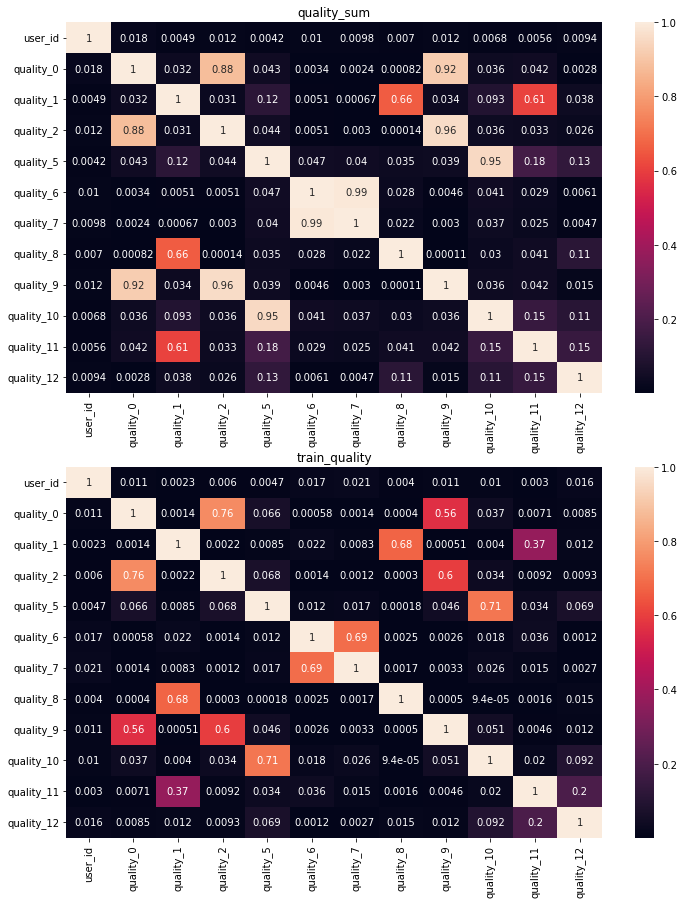

In [9]:
plt.figure(figsize=(12,15))
plt.subplot(2,1,1)
plt.title("quality_sum")
sns.heatmap(abs(quality_sum.corr()), annot=True)

plt.subplot(2,1,2)
plt.title("train_quality")
sns.heatmap(abs(train_quality.corr()), annot=True)

# 모든 quality값을 합쳤을 때 quality 컬럼들 간의 상관관계가 더 높다

In [15]:
# 중복정보가 있는 column 제거
def remove_collinearity(X, threshold):
    """
    X : feature matrix
    threshold : 다중공선성을 제거할 column을 고르는 기준 값. [0, 1]
    """
    
    corr = X.corr()
    candidate_cols = []
    
    for x in corr.iterrows():
        idx, row = x[0], x[1] # decoupling tuple
        if idx in candidate_cols:
            continue
        candidates = row[row > threshold].index[1:]

        # 자기 자신을 제외하고 threshold를 넘는 column이 있다면 제거 할 column이다.
        if len(candidates) != 0:
            for col in candidates:
                candidate_cols.append(col)           
    
    return candidate_cols

In [16]:
correlated_features = remove_collinearity(quality_sum, 0.7)
print(correlated_features)
quality_sum = quality_sum.drop(columns=correlated_features)
quality_sum.columns[1:]

['quality_2', 'quality_9', 'quality_10', 'quality_7']


Index(['quality_0', 'quality_1', 'quality_5', 'quality_6', 'quality_8',
       'quality_11', 'quality_12'],
      dtype='object')

In [18]:
# quality 컬럼별 불만 제기율 분석
# quality_0

quality_0_user = quality_sum.groupby('quality_0')['user_id'].unique().to_frame().reset_index()
quality_0_user['counts'] = 0
quality_0_user['rate'] = 0
quality_0_user

,quality_0,user_id,counts,rate
0,-157.0,[15475],0,0
1,-153.0,[21641],0,0
2,-144.0,[11252],0,0
3,-142.0,"[16101, 23927]",0,0
4,-139.0,[16147],0,0
...,...,...,...,...
167,175306.0,[20204],0,0
168,185198.0,[24489],0,0
169,397420.0,[24496],0,0
170,416301.0,[13186],0,0


In [19]:
for i in range(len(quality_0_user.index)):
    quality_0_user['counts'][i] = len(list(train_problem[train_problem['user_id'].isin(quality_0_user['user_id'][i])].user_id.unique()))
    
quality_0_user['rate'] = quality_0_user['counts'].values / quality_0_user['user_id'].str.len().values * 100
quality_0_user

,quality_0,user_id,counts,rate
0,-157.0,[15475],1,100.0
1,-153.0,[21641],1,100.0
2,-144.0,[11252],1,100.0
3,-142.0,"[16101, 23927]",1,50.0
4,-139.0,[16147],1,100.0
...,...,...,...,...
167,175306.0,[20204],1,100.0
168,185198.0,[24489],0,0.0
169,397420.0,[24496],0,0.0
170,416301.0,[13186],1,100.0


In [24]:
# quality_1
quality_1_user = quality_sum.groupby('quality_1')['user_id'].unique().to_frame().reset_index()
quality_1_user['counts'] = 0
quality_1_user['rate'] = 0

for i in range(len(quality_1_user.index)):
    quality_1_user['counts'][i] = len(list(train_problem[train_problem['user_id'].isin(quality_1_user['user_id'][i])].user_id.unique()))
    
quality_1_user['rate'] = quality_1_user['counts'].values / quality_1_user['user_id'].str.len().values * 100

In [25]:
# quality_5
quality_5_user = quality_sum.groupby('quality_5')['user_id'].unique().to_frame().reset_index()
quality_5_user['counts'] = 0
quality_5_user['rate'] = 0

for i in range(len(quality_5_user.index)):
    quality_5_user['counts'][i] = len(list(train_problem[train_problem['user_id'].isin(quality_5_user['user_id'][i])].user_id.unique()))
    
quality_5_user['rate'] = quality_5_user['counts'].values / quality_5_user['user_id'].str.len().values * 100

In [26]:
# quality_6
quality_6_user = quality_sum.groupby('quality_6')['user_id'].unique().to_frame().reset_index()
quality_6_user['counts'] = 0
quality_6_user['rate'] = 0

for i in range(len(quality_6_user.index)):
    quality_6_user['counts'][i] = len(list(train_problem[train_problem['user_id'].isin(quality_6_user['user_id'][i])].user_id.unique()))
    
quality_6_user['rate'] = quality_6_user['counts'].values / quality_6_user['user_id'].str.len().values * 100

In [27]:
# quality_8
quality_8_user = quality_sum.groupby('quality_8')['user_id'].unique().to_frame().reset_index()
quality_8_user['counts'] = 0
quality_8_user['rate'] = 0

for i in range(len(quality_8_user.index)):
    quality_8_user['counts'][i] = len(list(train_problem[train_problem['user_id'].isin(quality_8_user['user_id'][i])].user_id.unique()))
    
quality_8_user['rate'] = quality_8_user['counts'].values / quality_8_user['user_id'].str.len().values * 100

In [28]:
# quality_11에서 같은 방식으로 분석
quality_11_user = quality_sum.groupby('quality_11')['user_id'].unique().to_frame().reset_index()
quality_11_user['counts'] = 0
quality_11_user['rate'] = 0

for i in range(len(quality_11_user.index)):
    quality_11_user['counts'][i] = len(list(train_problem[train_problem['user_id'].isin(quality_11_user['user_id'][i])].user_id.unique()))
    
quality_11_user['rate'] = quality_11_user['counts'].values / quality_11_user['user_id'].str.len().values * 100

In [29]:
# quality_12
quality_12_user = quality_sum.groupby('quality_12')['user_id'].unique().to_frame().reset_index()
quality_12_user['counts'] = 0
quality_12_user['rate'] = 0

for i in range(len(quality_12_user.index)):
    quality_12_user['counts'][i] = len(list(train_problem[train_problem['user_id'].isin(quality_12_user['user_id'][i])].user_id.unique()))
    
quality_12_user['rate'] = quality_12_user['counts'].values / quality_12_user['user_id'].str.len().values * 100

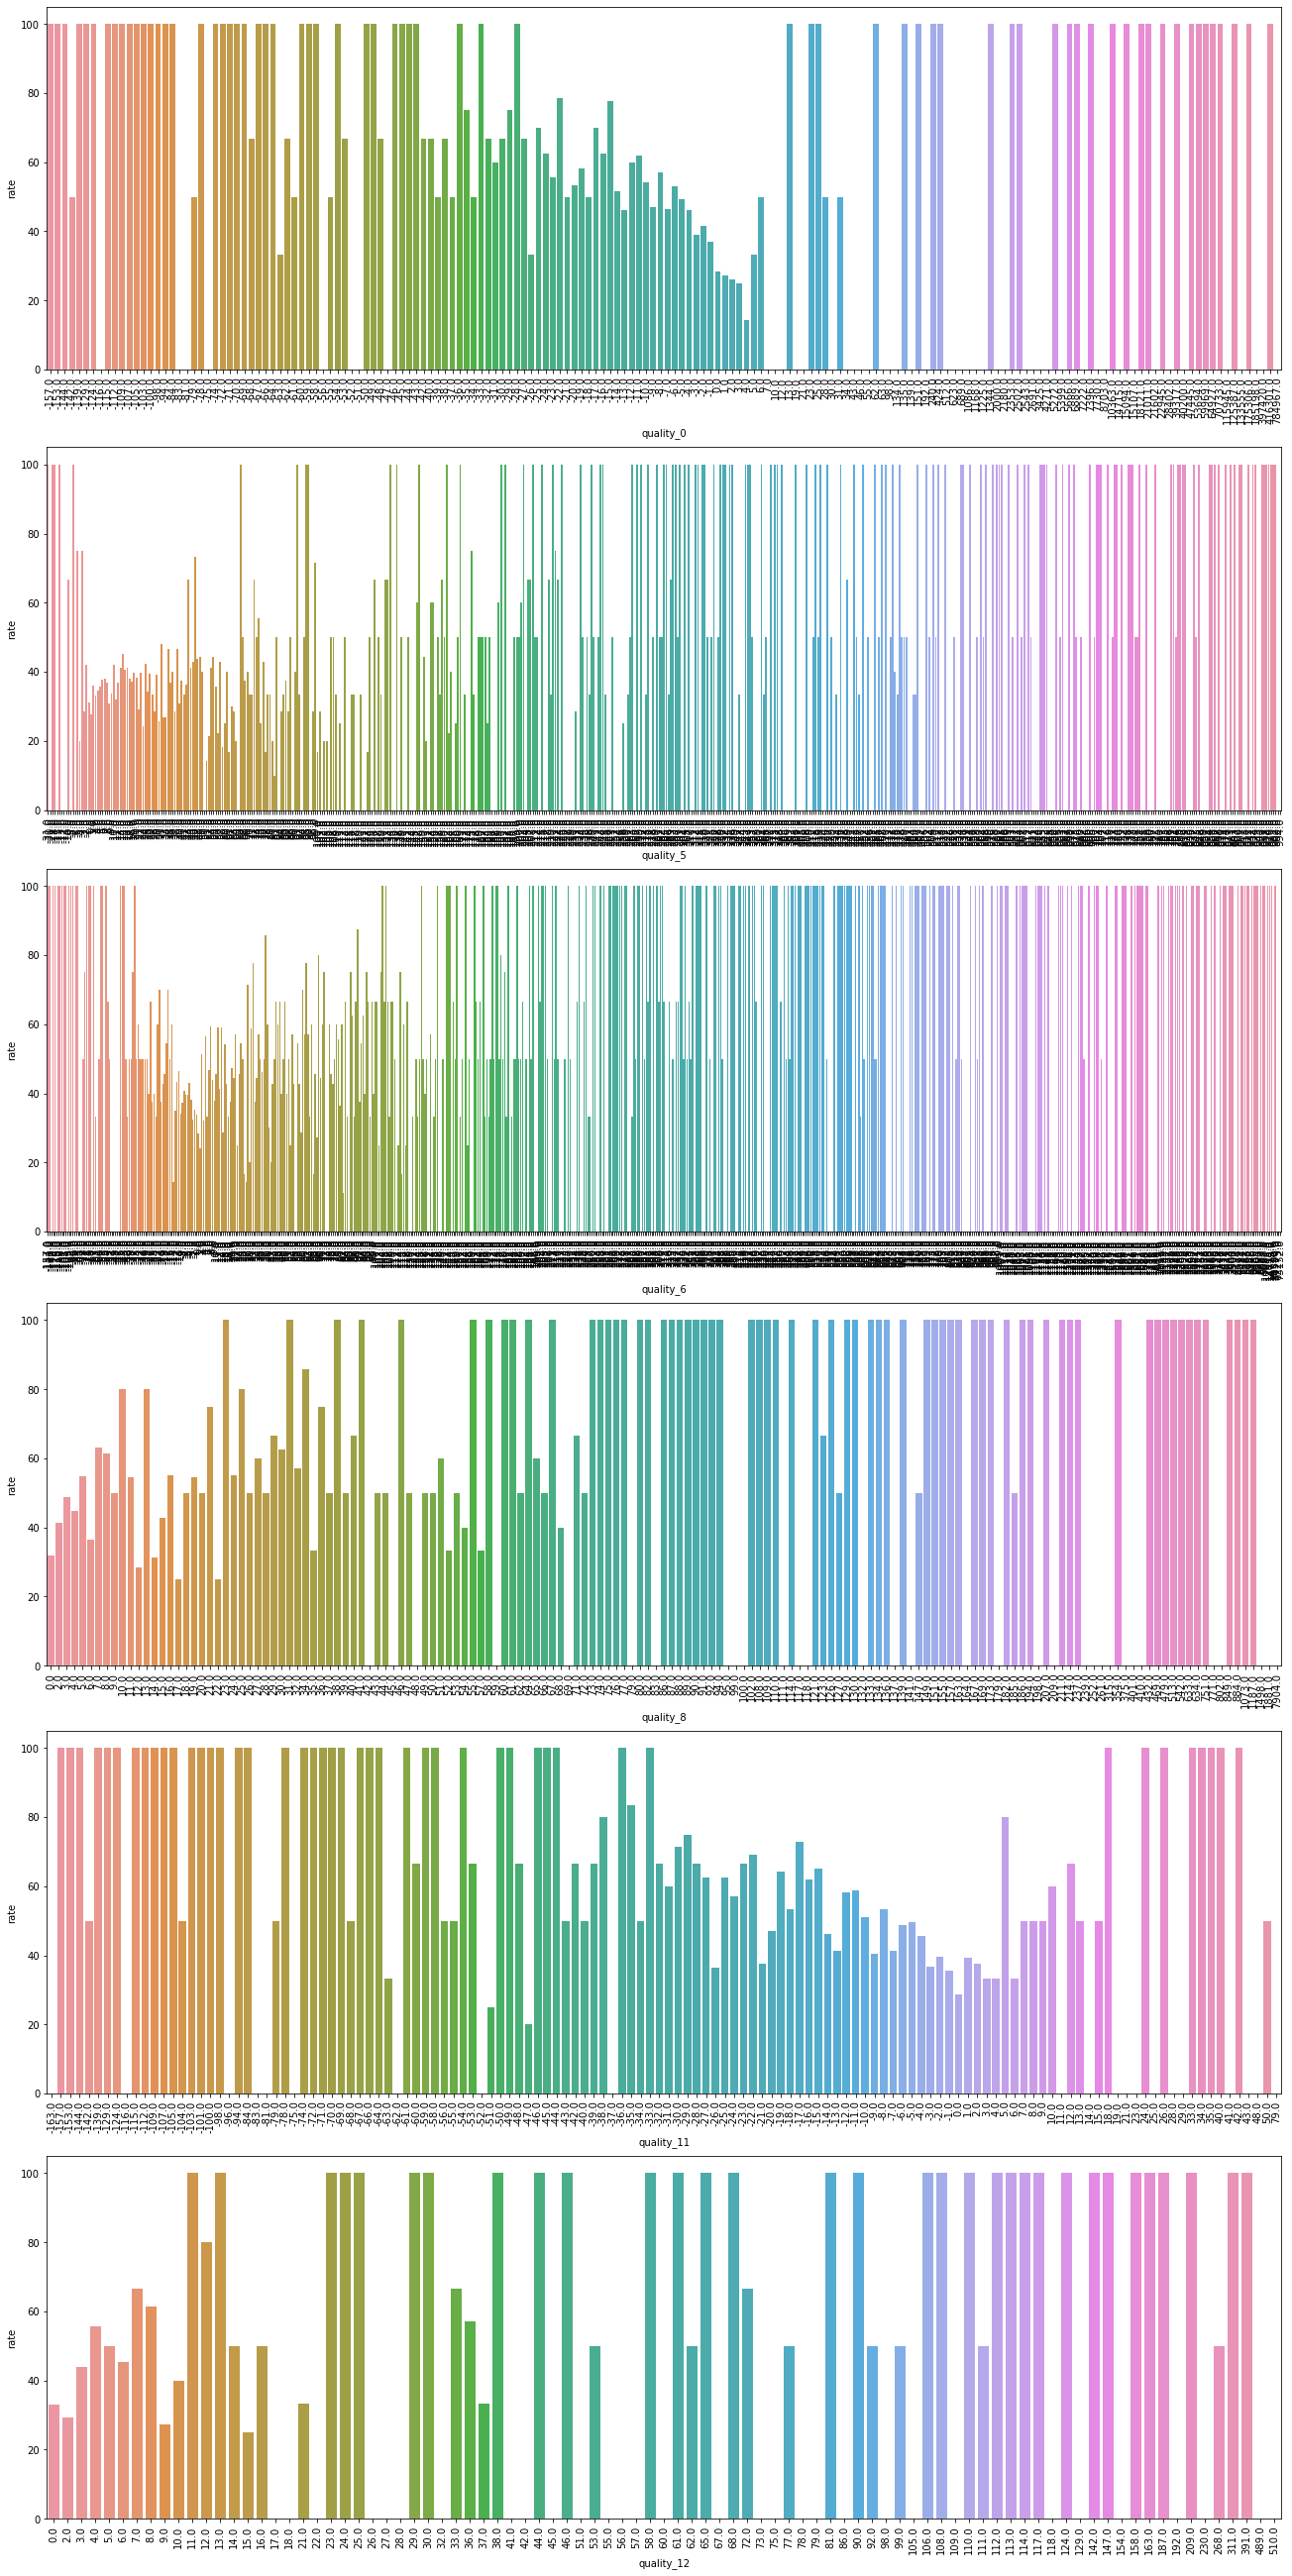

In [41]:
# 각 데이터프레임 그래프로 그려보기

fig, axes = plt.subplots(6,1, figsize=(18,36), constrained_layout=True)
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=90)

sns.barplot(data=quality_0_user, x='quality_0', y='rate', ax=axes[0])
sns.barplot(data=quality_5_user[quality_5_user.quality_5 < 1000], x='quality_5', y='rate', ax=axes[1])
sns.barplot(data=quality_6_user, x='quality_6', y='rate', ax=axes[2])
sns.barplot(data=quality_8_user, x='quality_8', y='rate', ax=axes[3])
sns.barplot(data=quality_11_user, x='quality_11', y='rate', ax=axes[4])
sns.barplot(data=quality_12_user, x='quality_12', y='rate', ax=axes[5])

plt.show()

- quality값의 총 합이 0이 될 수록 불만 제기율이 떨어지는 양상을 보인다.